# Demonstrator for dense correlator in OpenCL

In [1]:
%matplotlib nbagg
from matplotlib.pyplot import subplots
import os, time, sys
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1"

In [2]:
import numpy
y,x = numpy.ogrid[-200:201,-300:301]
r = (x**2+y**2)**0.5
shape = r.shape
qbin = (r//10).astype(int)
shape

(401, 601)

<IPython.core.display.Javascript object>


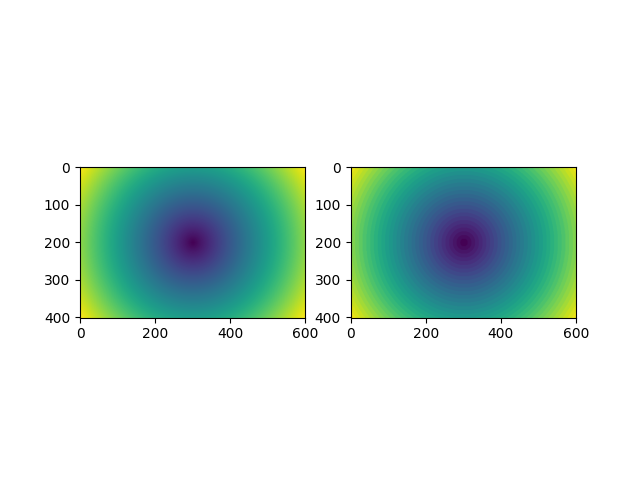

In [3]:
fig,ax = subplots(1, 2)
ax[0].imshow(r)
ax[1].imshow(qbin)

In [4]:
%%time
pixel_cnt = numpy.bincount(qbin.ravel())
mask_ptr = numpy.concatenate(([0], pixel_cnt.cumsum()))
nbins = qbin.max()+1
positions = numpy.arange(nbins)
pixel_cnt

CPU times: user 1.11 ms, sys: 419 µs, total: 1.53 ms
Wall time: 967 µs


array([  305,   940,  1564,  2204,  2812,  3452,  4084,  4708,  5364,
        5964,  6572,  7244,  7828,  8476,  9144,  9708, 10380, 11004,
       11604, 12252, 11318, 10340,  9948,  9576,  9392,  9232,  9088,
        8988,  8896,  8816,  6854,  4868,  3564,  2472,  1476,   556,
           8])

In [5]:
%%time
from scipy.sparse import csc_matrix
row = numpy.digitize(qbin.ravel(), positions)-1
size = row.size
col = numpy.arange(size)
dat = numpy.ones(size, dtype=float)
csc = csc_matrix((dat, (row, col)), shape = (nbins, size))
print(csc.shape)

(37, 241001)
CPU times: user 21.8 ms, sys: 3.2 ms, total: 25 ms
Wall time: 24.2 ms


In [6]:
%time csr = csc.tocsr()

CPU times: user 6.69 ms, sys: 991 µs, total: 7.68 ms
Wall time: 6.77 ms


In [7]:
csr.indices

array([115087, 115088, 115089, ..., 240399, 240400, 241000], dtype=int32)

# Implement dense correlator in OpenCL...

In [8]:
%%time
nframes = 1000
stack = numpy.random.randint(0, 10, size = (nframes,)+shape).astype("uint8")

CPU times: user 2.59 s, sys: 165 ms, total: 2.75 s
Wall time: 2.75 s


In [9]:
%load_ext pyopencl.ipython_ext
%load_ext line_profiler

In [10]:
import pyopencl  as cl
from pyopencl import array as cla

ctx = cl.create_some_context(interactive=0)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
ctx

<pyopencl.Context at 0x55c35cf3f7e0 on <pyopencl.Device 'GeForce GTX TITAN' on 'NVIDIA CUDA' at 0x55c35d6bbab0>>

In [11]:
%%cl_kernel
/*Size if the kernel: dim0: qbin 
                      dim1: tau    
*/


kernel void correlator_multiQ_dense(
    const global char* frames,
    const global int* q_mask_ptr,
    const global int* q_mask_pixels,
    global float* out_mean,
    global float* out_std,
    const int Nt,
    const int image_size
) {
    uint qbin = get_global_id(0);
    uint tau = get_global_id(1);
    const int start = q_mask_ptr[qbin+1];
    const int stop = q_mask_ptr[qbin+2];
    const int npix = stop - start;

    // Barrier for thread index
    if (tau >= Nt) return;
    
    ulong denom_a, denom_b, num, num2, denom2_a, denom2_b, denom;
    double denom2, sum2, mean;

    num = 0;
    num2 = 0;
    denom = 0;
    denom2 = 0.0;
    sum2 = 0.0;
    
    for (int t = tau; t < Nt; t++) {
        num2 = 0;
        denom_a = 0;
        denom_b = 0;
        for (int idx = start; idx < stop; idx++) {
            int pix_idx = q_mask_pixels[idx];
            uint val1 = frames[t*image_size + pix_idx];
            uint val2 = frames[(t-tau)*image_size + pix_idx];
            uint prod = val1*val2;
            num += prod;
            num2 += prod;
            denom_a +=val1;
            denom_b +=val2;
        }
        denom += denom_a * denom_b;
        sum2 += pown(1.0 * num2 / (denom_a * denom_b), 2);
    }
    mean = 1.0 * npix * num / denom;
    out_mean[qbin*Nt + tau] = mean;
    out_std[qbin*Nt + tau] = sqrt((npix*npix*sum2/(Nt-tau) - mean*mean)/(Nt-tau));
}


In [12]:
d_frames = cla.to_device(queue, stack)
d_q_mask_ptr = cla.to_device(queue, csr.indptr)
d_q_mask_pix = cla.to_device(queue, csr.indices)
d_avg = cla.zeros(queue, (nbins-1,nframes), dtype="float32")
d_std = cla.zeros(queue, (nbins-1,nframes), dtype="float32")
t0 = time.perf_counter()
wg = 128
evt = correlator_multiQ_dense(queue, (nbins-1, (nframes+wg)//wg*wg), (1,wg),
                            d_frames.data,
                            d_q_mask_ptr.data,
                            d_q_mask_pix.data,
                            d_avg.data,
                            d_std.data,
                            numpy.int32(nframes),
                            numpy.int32(qbin.size))

In [13]:
evt.wait()
print(time.perf_counter()-t0)
(evt.profile.end-evt.profile.start)*1e-9

35.77061462006532


35.769811936

In [14]:
d_avg.get()[0]#-res[0][0]

array([1.4070797 , 1.0005654 , 0.99974805, 0.99983627, 1.0004206 ,
       1.0000817 , 0.9994909 , 0.9997279 , 1.0003155 , 1.0003253 ,
       1.0000514 , 1.0008512 , 1.0003548 , 1.0003245 , 1.0000995 ,
       1.0001516 , 0.9998477 , 0.99945945, 1.0000798 , 1.0005963 ,
       0.9995903 , 1.0007085 , 1.0000206 , 0.9997622 , 1.0002805 ,
       0.99939924, 1.0003681 , 0.9995328 , 0.9998136 , 1.000195  ,
       1.0000182 , 0.9994262 , 0.99979377, 0.9998884 , 1.000277  ,
       1.0000784 , 1.0005195 , 0.9997535 , 0.99963707, 1.0008079 ,
       1.0001729 , 0.9997834 , 0.99985766, 0.9998831 , 0.9997312 ,
       1.0000682 , 1.000149  , 0.99998873, 0.9994447 , 1.0001423 ,
       0.9995757 , 1.0000149 , 0.9996537 , 1.0000302 , 1.0000634 ,
       0.9996363 , 1.0002946 , 0.99940914, 1.0001422 , 0.99941814,
       1.00034   , 1.0001469 , 0.99993193, 0.9996828 , 1.0006301 ,
       0.99946964, 1.000271  , 1.0000428 , 1.0000167 , 0.99960166,
       1.000268  , 0.9996703 , 0.999769  , 0.9994725 , 1.00016

In [15]:
(evt.profile.end-evt.profile.start)*1e-9

35.769811936

In [16]:
from dynamix.correlator import dense

/users/kieffer/.venv/py39/lib/python3.9/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [17]:
d=dense.MatMulCorrelator(shape, nframes, qmask=qbin)

In [18]:
%time res = d.correlate(stack, calc_std=True)

CPU times: user 29.1 s, sys: 17.9 s, total: 47.1 s
Wall time: 5.65 s


In [19]:
# %lprun -f d.correlate res = d.correlate(stack, calc_std=True)

In [20]:
#  %lprun -f sys.modules[d.__module__].__getattribute__("py_dense_correlator") res = d.correlate(stack, calc_std=True)

<IPython.core.display.Javascript object>


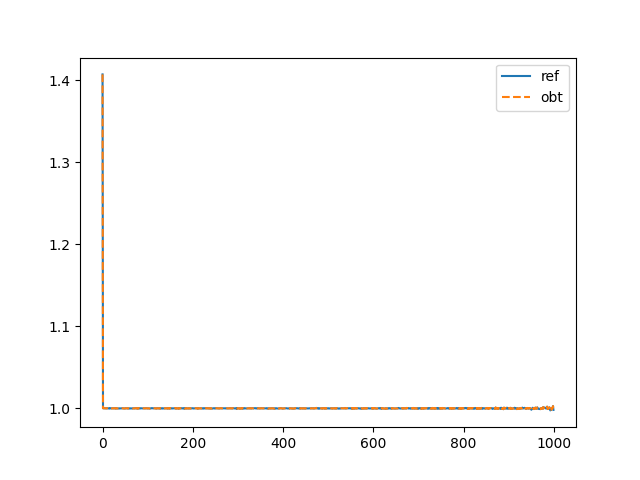

In [21]:
fig, ax = subplots()
bin = 16
ax.plot(res[0][bin], label="ref")
ax.plot(d_avg.get()[bin], "--", label="obt")
ax.legend()

<IPython.core.display.Javascript object>


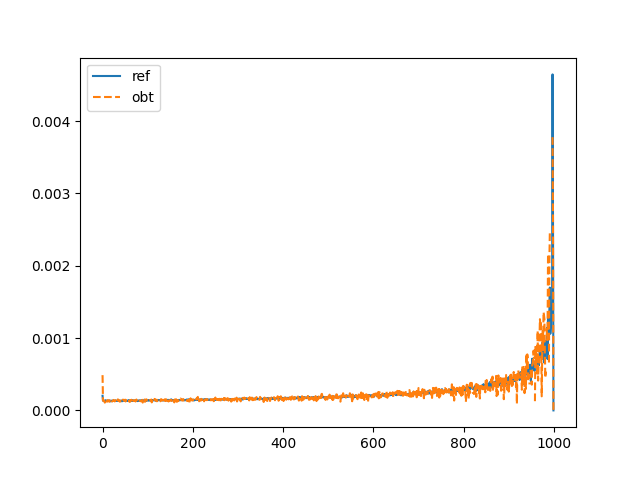

In [22]:
fig, ax = subplots()
bin = 14
ax.plot(res[1][bin], label="ref")
ax.plot(d_std.get()[bin], "--", label="obt")
ax.legend()